In [2]:
%run imports.ipynb

In [11]:
merged_data= pd.read_csv('Averaged_BearingTest_Dataset.csv', index_col=0)
#merged_data.head()

In [12]:
train = merged_data['2004-02-12 10:52:39': '2004-02-15 12:52:39']
test = merged_data['2004-02-15 12:52:39':]
#print("Training dataset shape:", train.shape)
#print("Test dataset shape:", test.shape)

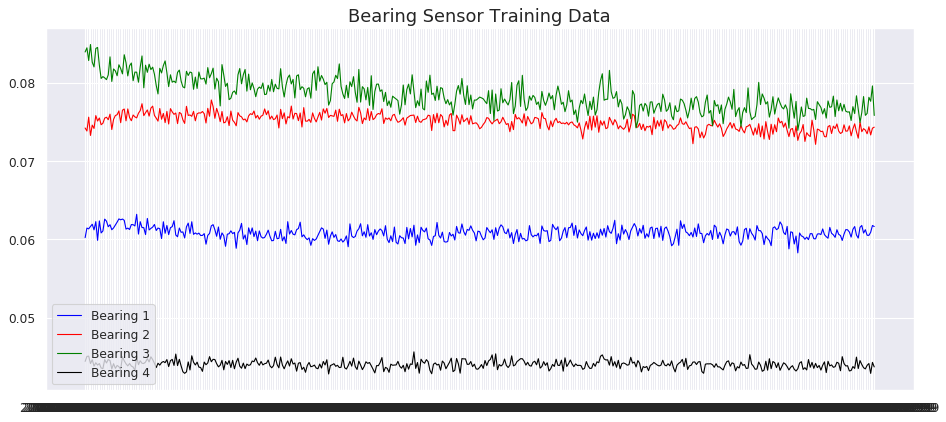

In [13]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(train['Bearing 1'], label='Bearing 1', color='blue', animated = True, linewidth=1)
ax.plot(train['Bearing 2'], label='Bearing 2', color='red', animated = True, linewidth=1)
ax.plot(train['Bearing 3'], label='Bearing 3', color='green', animated = True, linewidth=1)
ax.plot(train['Bearing 4'], label='Bearing 4', color='black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Training Data', fontsize=16)
plt.show()

In [14]:
# transforming data from the time domain to the frequency domain using fast Fourier transform
train_fft = np.fft.fft(train)
test_fft = np.fft.fft(test)

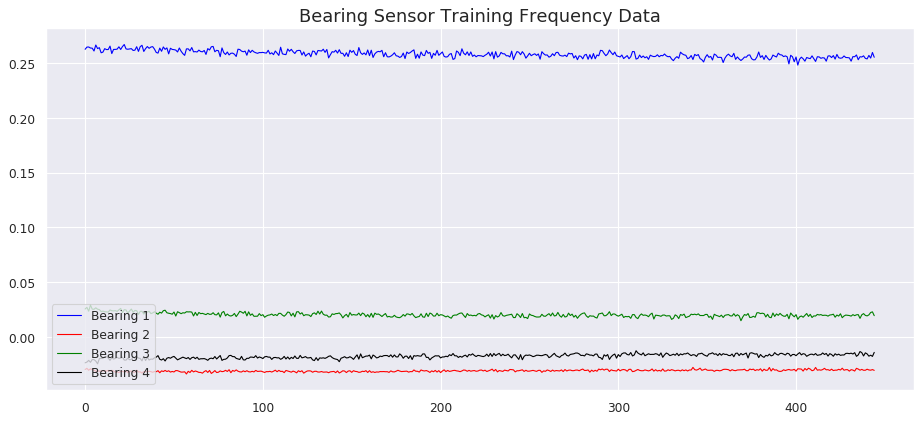

In [15]:
# frequencies of the healthy sensor signal
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(train_fft[:,0].real, label='Bearing 1', color='blue', animated = True, linewidth=1)
ax.plot(train_fft[:,1].imag, label='Bearing 2', color='red', animated = True, linewidth=1)
ax.plot(train_fft[:,2].real, label='Bearing 3', color='green', animated = True, linewidth=1)
ax.plot(train_fft[:,3].real, label='Bearing 4', color='black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Training Frequency Data', fontsize=16)
plt.show()

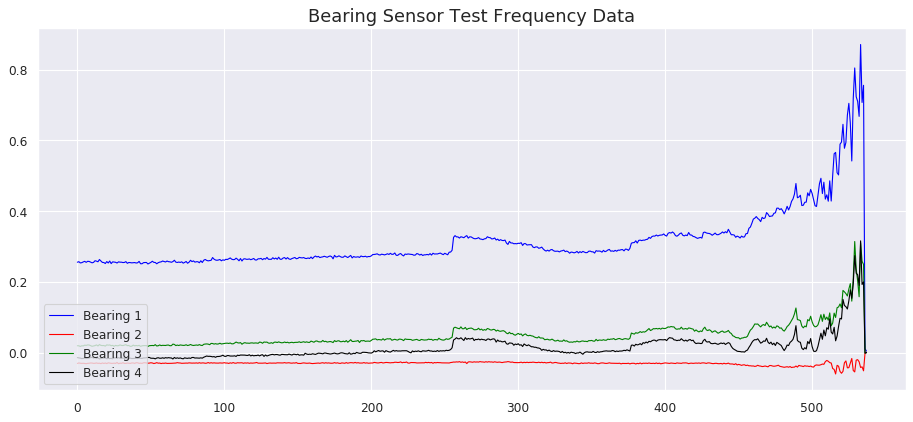

In [16]:
# frequencies of the degrading sensor signal
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(test_fft[:,0].real, label='Bearing 1', color='blue', animated = True, linewidth=1)
ax.plot(test_fft[:,1].imag, label='Bearing 2', color='red', animated = True, linewidth=1)
ax.plot(test_fft[:,2].real, label='Bearing 3', color='green', animated = True, linewidth=1)
ax.plot(test_fft[:,3].real, label='Bearing 4', color='black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Test Frequency Data', fontsize=16)
plt.show()

In [17]:
# normalize the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train)
X_test = scaler.transform(test)
scaler_filename = "scaler_data"
joblib.dump(scaler, scaler_filename)

['scaler_data']

In [18]:
# reshape inputs for LSTM [samples, timesteps, features]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print("Test data shape:", X_test.shape)

Training data shape: (445, 1, 4)
Test data shape: (538, 1, 4)


In [19]:
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

In [20]:
# create the autoencoder model
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 4)              0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 16)             1344      
_________________________________________________________________
lstm_2 (LSTM)                (None, 4)                 336       
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 1, 4)              0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 4)              144       
_________________________________________________________________
lstm_4 (LSTM)                (None, 1, 16)             1344      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 1, 4)              68  

In [21]:
# fit the model to the data
nb_epochs = 100
batch_size = 10
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size, validation_split=0.05).history

Train on 422 samples, validate on 23 samples
Epoch 1/100
422/422 [==============================] - 2s 4ms/step - loss: 0.4472 - val_loss: 0.3244
Epoch 2/100
422/422 [==============================] - 0s 382us/step - loss: 0.3899 - val_loss: 0.2580
Epoch 3/100
422/422 [==============================] - 0s 382us/step - loss: 0.3121 - val_loss: 0.1796
Epoch 4/100
422/422 [==============================] - 0s 381us/step - loss: 0.2059 - val_loss: 0.1589
Epoch 5/100
422/422 [==============================] - 0s 375us/step - loss: 0.1274 - val_loss: 0.1402
Epoch 6/100
422/422 [==============================] - 0s 362us/step - loss: 0.1084 - val_loss: 0.1230
Epoch 7/100
422/422 [==============================] - 0s 391us/step - loss: 0.1040 - val_loss: 0.1186
Epoch 8/100
422/422 [==============================] - 0s 375us/step - loss: 0.1026 - val_loss: 0.1150
Epoch 9/100
422/422 [==============================] - 0s 369us/step - loss: 0.1021 - val_loss: 0.1147
Epoch 10/100
422/422 [========

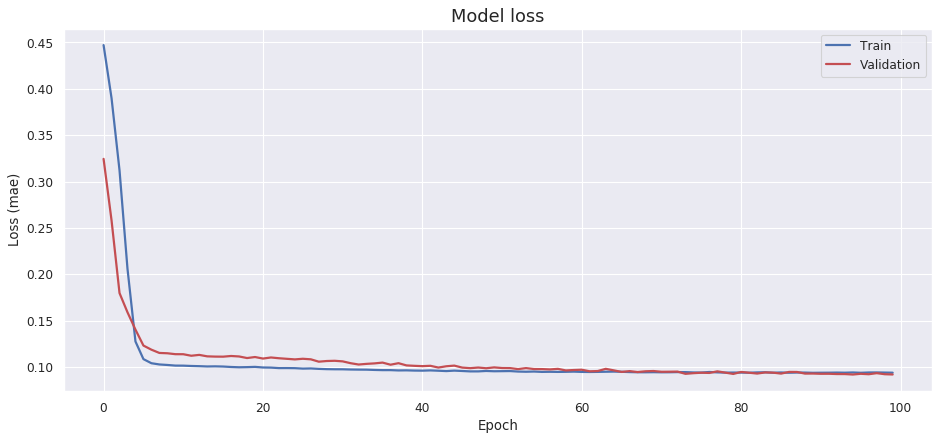

In [22]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

### Distribution of Loss Function
By plotting the distribution of the calculated loss in the training set, one can use this to identify a suitable threshold value for identifying an anomaly. In doing this, one can make sure that this threshold is set above the “noise level” and that any flagged anomalies should be statistically significant above the background noise.

(0.0, 0.5)

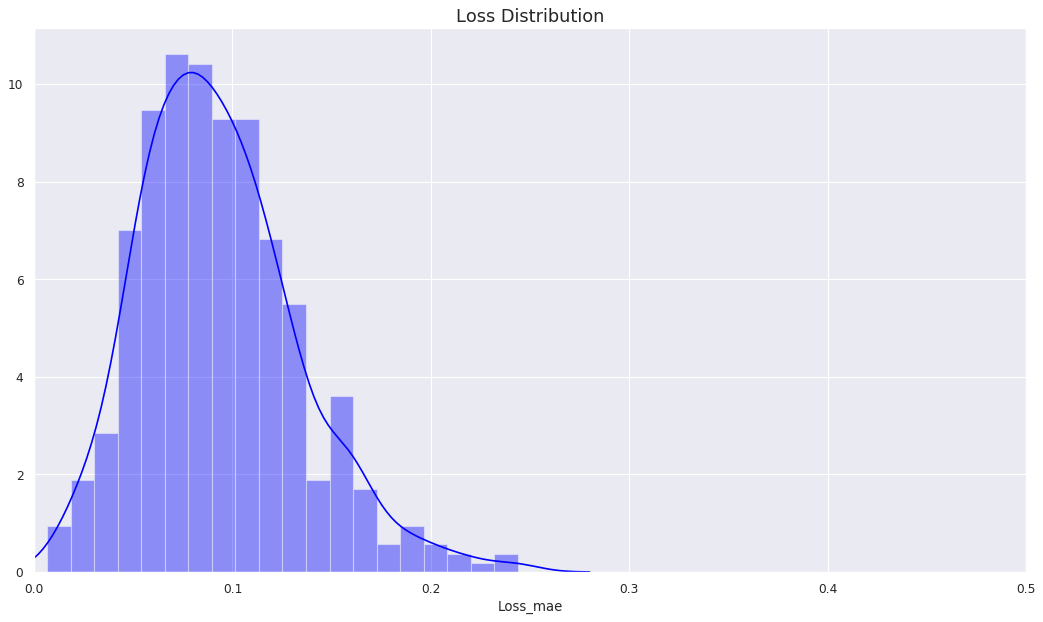

In [23]:
# plot the loss distribution of the training set
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=train.columns)
X_pred.index = train.index

scored = pd.DataFrame(index=train.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,.5])

In [24]:
# calculate the loss on the test set
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=test.columns)
X_pred.index = test.index

scored = pd.DataFrame(index=test.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
scored['Threshold'] = 0.275
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()

,Loss_mae,Threshold,Anomaly
2004-02-15 12:52:39,0.093890,0.275,False
2004-02-15 13:02:39,0.171006,0.275,False
2004-02-15 13:12:39,0.067868,0.275,False
2004-02-15 13:22:39,0.053795,0.275,False
2004-02-15 13:32:39,0.038406,0.275,False


In [25]:
# calculate the same metrics for the training set 
# and merge all data in a single dataframe for plotting
X_pred_train = model.predict(X_train)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train, columns=train.columns)
X_pred_train.index = train.index

scored_train = pd.DataFrame(index=train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-Xtrain), axis = 1)
scored_train['Threshold'] = 0.275
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])

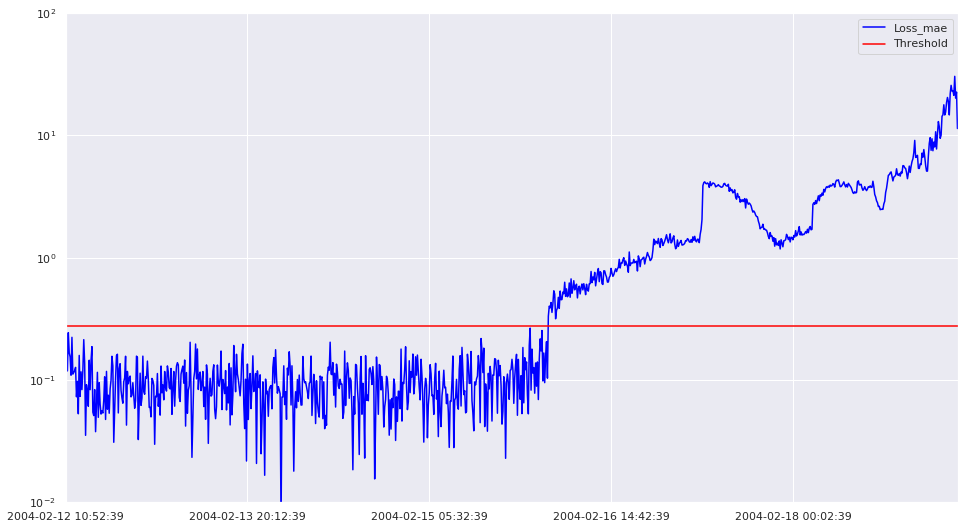

In [26]:
# plot bearing failure time plot
scored.plot(logy=True,  figsize=(16,9), ylim=[1e-2,1e2], color=['blue','red'])

In [27]:
# save all model information, including weights, in h5 format
model.save("Cloud_model.h5")
print("Model saved")

Model saved
